In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Corner Detection

In [242]:
# read in and convert image to appropriate format for corner detection
img = cv2.imread('images/3.jpg')
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
(thresh, bw_img) = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
gray = np.float32(bw_img)

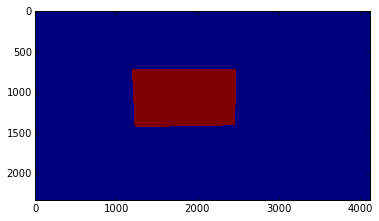

In [243]:
plt.imshow(bw_img);

In [244]:
# corner detection
dst = cv2.cornerHarris(bw_img,5,3,0.04)
dst = cv2.dilate(dst,None)

In [245]:
# mark points located by algorithm
corner_img = np.array(img)
corner_img[dst>0]=[255,0,0]

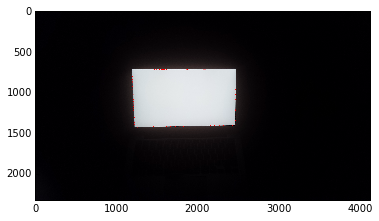

In [246]:
plt.imshow(corner_img);

## Edge Detection

In [334]:
img = cv2.imread('images/2.jpg')
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
(thresh, bw_img) = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

In [335]:
edges = cv2.Canny(gray_img, threshold1=thresh, threshold2=thresh*2, apertureSize=3)
edge_img = np.array(img)
edge_img[edges>0]=[255,0,0]

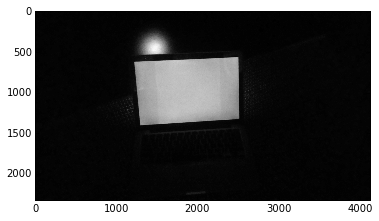

In [336]:
plt.imshow(gray_img, cmap='gray');

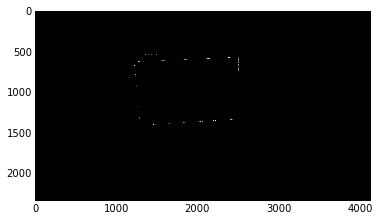

In [337]:
plt.imshow(edges, cmap='gray', clim=(0,255));

## Hough Lines

In [338]:
# Probabalistic (line segments)
line_img = np.array(img)
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edges,1,np.pi/180, 80,100,minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[0]:
    cv2.line(line_img,(x1,y1),(x2,y2),(255,0,0),10, lineType=4)

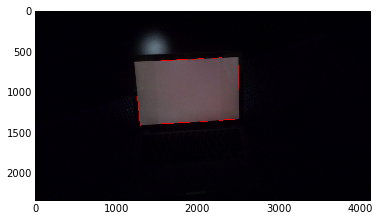

In [339]:
plt.imshow(line_img);

In [268]:
def group_lines(lines):
    '''
    Groups lines returned by HoughLinesP into top, bottom, left, and right edges.
    '''
    horz = []
    vert = []
    # split into horizontal and vertical lines
    for x1,y1,x2,y2 in lines:
        # if change in x is less than in y, then classify as vertical
        if np.abs(x1-x2) < np.abs(y1-y2):
            vert.append((x1,y1,x2,y2))
        else:
            horz.append((x1,y1,x2,y2))
    
    # find (very) approximate center of edges
    horz = np.array(horz)
    vert = np.array(vert)
    x_center = horz.mean(axis=0)[0]
    y_center = vert.mean(axis=0)[1]
    
    # split horizontal lines into top and bottom
    top = []
    bottom = []
    for x1,y1,x2,y2 in horz:
        if y1 < y_center:
            top.append((x1, y1))
            top.append((x2, y2))
        else:
            bottom.append((x1, y1))
            bottom.append((x2, y2))
    top = np.array(top)
    bottom = np.array(bottom)
    
    # split vertical lines into left and right
    left = []
    right = []
    for x1,y1,x2,y2 in vert:
        if x1 > x_center:
            right.append((x1, y1))
            right.append((x2, y2))
        else:
            left.append((x1, y1))
            left.append((x2, y2))
    left = np.array(left)
    right = np.array(right)
    
    # return points that consist each edge of the screen
    return ((top, bottom) , (left, right))

In [269]:
def fit_edges(groups):
    '''
    Takes grouped points and fits lines to them
    '''
    horz = groups[0]
    vert = groups[1]
    
    h_fits = []
    v_fits = []
    for group in horz:
        h_fits.append(np.polyfit(group[:,0], group[:,1], 1)) # fit line as function of x values
    for group in vert:
        v_fits.append(np.polyfit(group[:,1], group[:,0], 1)) # fit line as function of y values
        
    return h_fits, v_fits

In [270]:
def get_lines(img, coefs):
    '''
    Takes linear fits and gets endpoints within the image
    '''
    plt_img = np.array(img)
    horz_coefs = coefs[0]
    vert_coefs = coefs[1]
    
    lines = []
    
    # get endpoints for horz lines
    for coef in horz_coefs:
        x1 = 0
        x2 = len(img[0,:]) - 1
        y1 = int(coef[1] + x1*coef[0])
        y2 = int(coef[1] + x2*coef[0])
        lines.append((x1,y1,x2,y2))
    
    # get endpoints for vert lines
    for coef in vert_coefs:
        y1 = 0
        y2 = len(img[:,0]) - 1
        x1 = int(coef[1] + y1*coef[0])
        x2 = int(coef[1] + y2*coef[0])
        lines.append((x1,y1,x2,y2))
    
    return lines

In [340]:
plt_lines = get_lines(img, fit_edges(group_lines(lines[0])))

In [341]:
plt_img = np.array(img)
for x1,y1,x2,y2 in plt_lines:
    cv2.line(plt_img,(x1,y1),(x2,y2),(255,0,0),10, lineType=4)

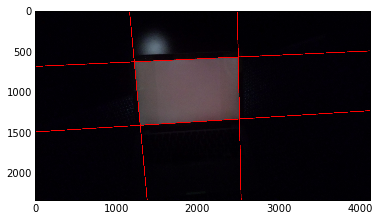

In [342]:
plt.imshow(plt_img);

In [291]:
def find_corners(img, lines):
    '''
    Find corners of screen within image based on edge lines.
    '''
    max_x = len(img[0,:]) - 1
    max_y = len(img[:,1]) - 1
    
    corners = []
    def intersects(l1, l2):
        x1, y1, x2, y2 = l1
        x3, y3, x4, y4 = l2
        
        divisor = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
        if divisor != 0:
            pt_x = ((x1*y2 - y1*x2) * (x3-x4) - (x1-x2) * (x3*y4 - y3*x4)) / divisor
            pt_y = ((x1*y2 - y1*x2) * (y3-y4) - (y1-y2) * (x3*y4 - y3*x4)) / divisor
            if pt_x >= 0 and pt_x <= max_x and pt_y >= 0 and pt_y <= max_y:
                return (pt_x, pt_y)
            else:
                return None
        else:
            return None
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            corner = intersects(lines[i], lines[j])
            if corner:
                corners.append(corner)
    return corners
            

In [343]:
corners = find_corners(img, plt_lines)

In [344]:
for corner in corners:
    cv2.circle(plt_img, corner, 25, [0,255,0], 10)

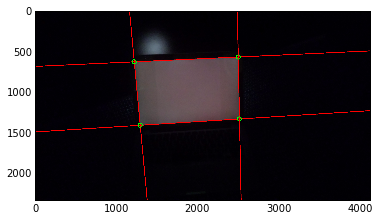

In [345]:
plt.imshow(plt_img);

In [350]:
def sort_corners(corners):
    '''
    Sort corners so that they are in clockwise order starting from the top-left
    '''
    ctr_x, ctr_y = np.array(corners).mean(axis=0)
    srtd_corners = list(corners)
    for x, y in corners:
        if x < ctr_x and y < ctr_y:
            srtd_corners[0] = (x, y)
        elif x > ctr_x and y < ctr_y:
            srtd_corners[1] = (x, y)
        elif x > ctr_x and y > ctr_y:
            srtd_corners[2] = (x, y)
        elif x < ctr_x and y > ctr_y:
            srtd_corners[3] = (x, y)
    return srtd_corners

In [351]:
corners = sort_corners(corners)

In [358]:
dest_corners = [(0,0), (1279,0), (1279,719), (0,719)]
trans = cv2.getPerspectiveTransform(np.array(corners).astype('float32'), np.array(dest_corners).astype('float32'))

In [360]:
trans_img = cv2.warpPerspective(img, trans, (1280,720))

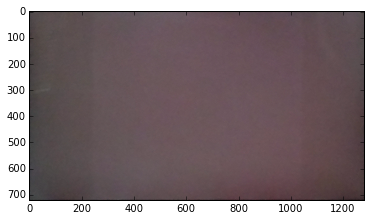

In [361]:
plt.imshow(trans_img);

## Segmentation

In [41]:
img = cv2.imread('images/3.jpg')
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_, bw_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
seg_img = np.array(img)
bw_img = bw_img.astype('int32')
bw_img[bw_img == 255] = 2
bw_img[bw_img == 0] = 1

In [42]:
cv2.watershed(seg_img, bw_img)


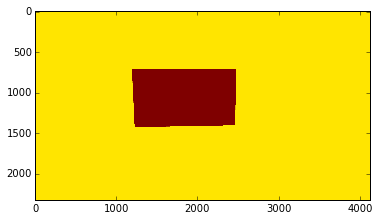

In [43]:
plt.imshow(bw_img);

In [44]:
np.unique(bw_img)

array([-1,  1,  2], dtype=int32)

In [45]:
bw_img[0,0]

-1